In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.vocab import build_vocab_from_iterator
import pickle
from pmf import PMF
from lr import LogReg
import numpy as np
from functools import reduce

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd

In [94]:
SEED = 42
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4, 5, 6]

df = pd.read_csv('data/men_data.csv')

In [215]:
def analyze_athlete(model, df):
    y_true = df['Status'].values
    y_pred = model.predict(df)
    y_pred_binary = np.round(y_pred)

    return accuracy_score(y_true, y_pred_binary)

def get_athlete_accuracy(df, model, names):
    accuracies = []
    for name in reversed(names):
        if name != 'other':
            df_climber = df.loc[df.Name == name]
        else:
            mask = df.Name.isin([climber for climber in model.climber_vocab.get_itos() if climber != 'other'])
            df_climber= df.loc[mask]
        accuracies.append(analyze_athlete(model, df_climber))
    return accuracies

In [226]:
def create_correlation_matrices():
    athletes = {}

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/complete/lr/model_rl_{replacement_level}_fold_0.pkl", 'rb') as f:            ########## CHANGE PATH FOR COMPLETE MODEL
            lr_model = pickle.load(f)

        fig, axs = plt.subplots(nrows=1, ncols=len(LATENT_FACTORS), figsize=(28, 8))

        for num_factors in LATENT_FACTORS:
            lr_weights = dict(zip(lr_model.climber_vocab.get_itos(), [lr_model.lr.intercept_[0]] + lr_model.lr.coef_.flatten().tolist()))

            lr_athletes = pd.DataFrame({
                "name": lr_model.climber_vocab.get_itos(),
                "coefs": [lr_weights[name] for name in lr_model.climber_vocab.get_itos()],
                # "pmf_accuracy": get_athlete_accuracy(df, lr_model, lr_model.climber_vocab.get_itos())
            }).set_index('name')

            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_1.pth")  ########## CHANGE PATH FOR COMPLETE MODEL
            pmf_model.eval()

            pmf_athletes = pd.DataFrame({
                "name": pmf_model.climber_vocab.get_itos(),
                "weights": pmf_model.climber_embedding.weight.data.numpy().tolist(),
                "pmf_accuracy": get_athlete_accuracy(df, pmf_model, pmf_model.climber_vocab.get_itos())
            })

            weights = pmf_athletes['weights'].apply(pd.Series)
            pmf_athletes = pd.concat([pmf_athletes[['name', 'pmf_accuracy']], weights], axis=1)
            pmf_athletes.columns = ['name', 'pmf_accuracy'] + [f'weight_{i+1}' for i in range(weights.shape[1])]
            pmf_athletes.set_index('name', inplace=True)

            ### Correlations
            lr_pmf_athletes = pd.merge(lr_athletes, pmf_athletes, left_index=True, right_index=True, how='outer')
            rows = [row for row in lr_pmf_athletes.columns if row.startswith('w')]
            cols = ['coefs', 'pmf_accuracy']
            df_corr = lr_pmf_athletes.corr().loc[rows, cols]
            sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[num_factors-1])


            athletes[f'{replacement_level}_{num_factors}'] = lr_pmf_athletes

        plt.suptitle(f'Correlation Matrices at RL: {replacement_level}', fontsize=16)

        plt.tight_layout()
        plt.savefig(f'figs/correlations_{replacement_level}')

/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Logisti

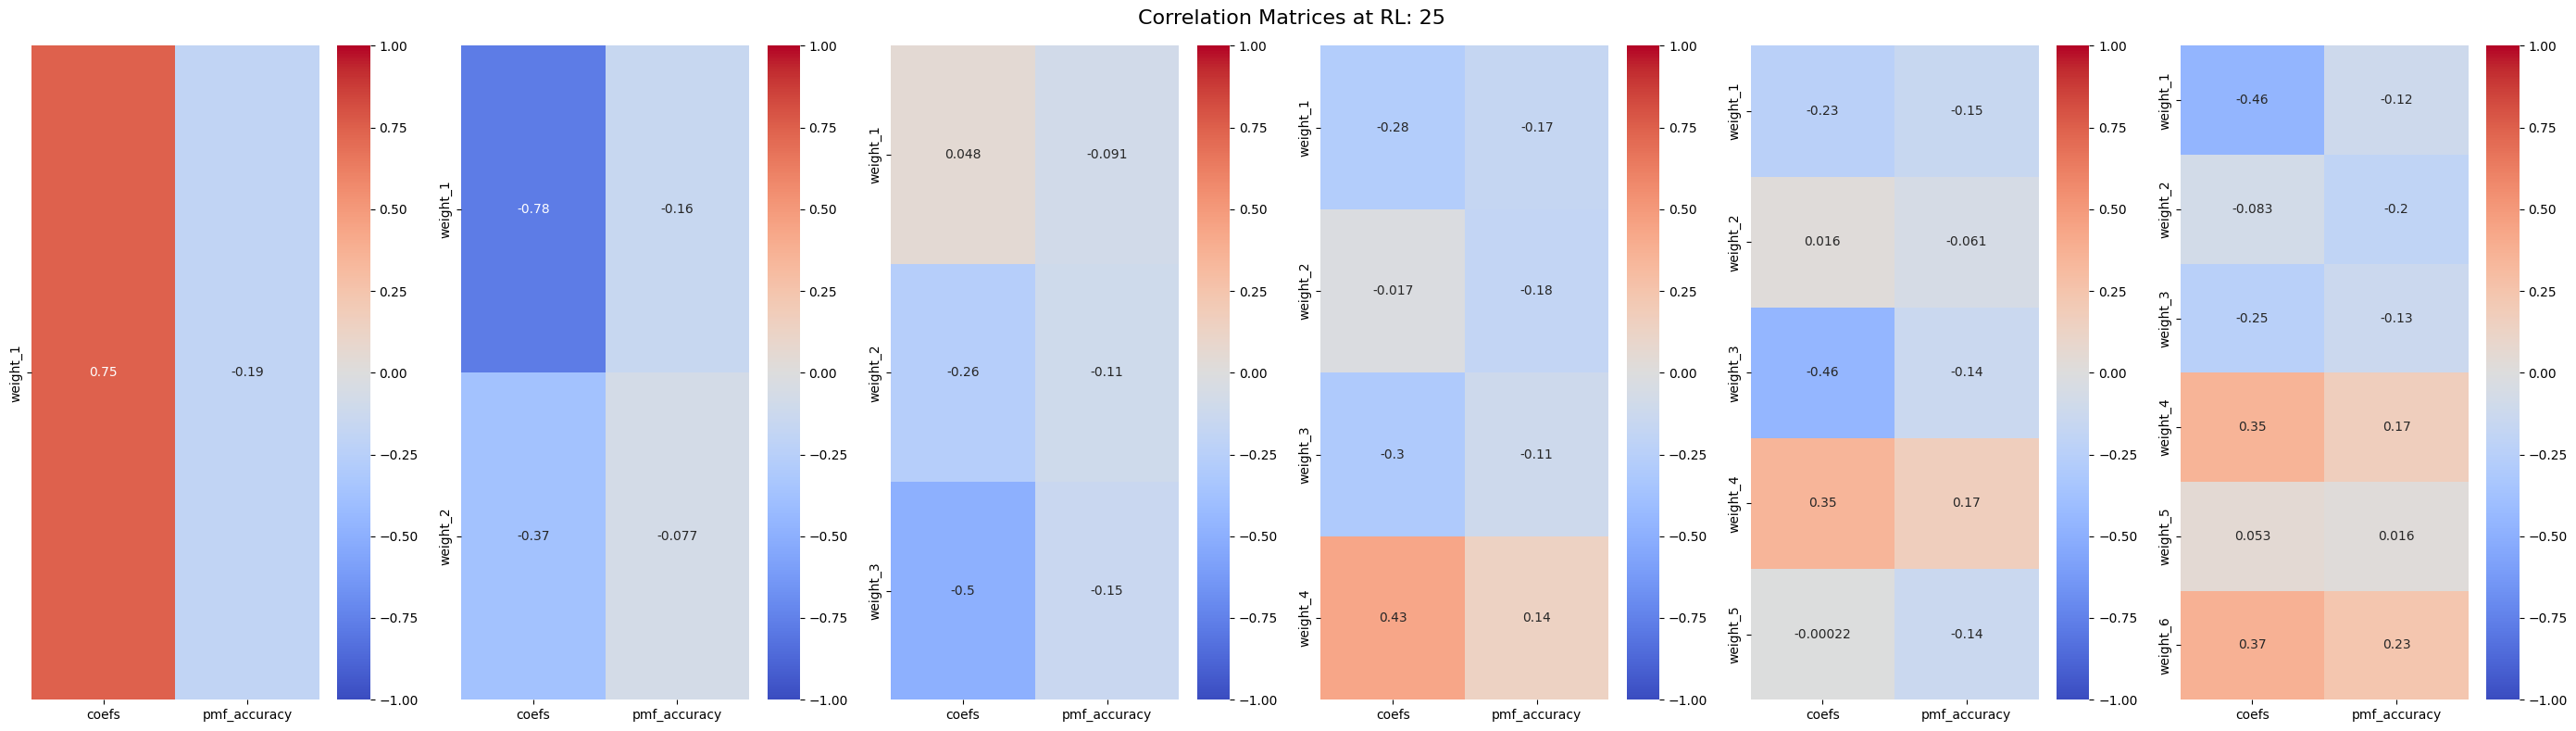

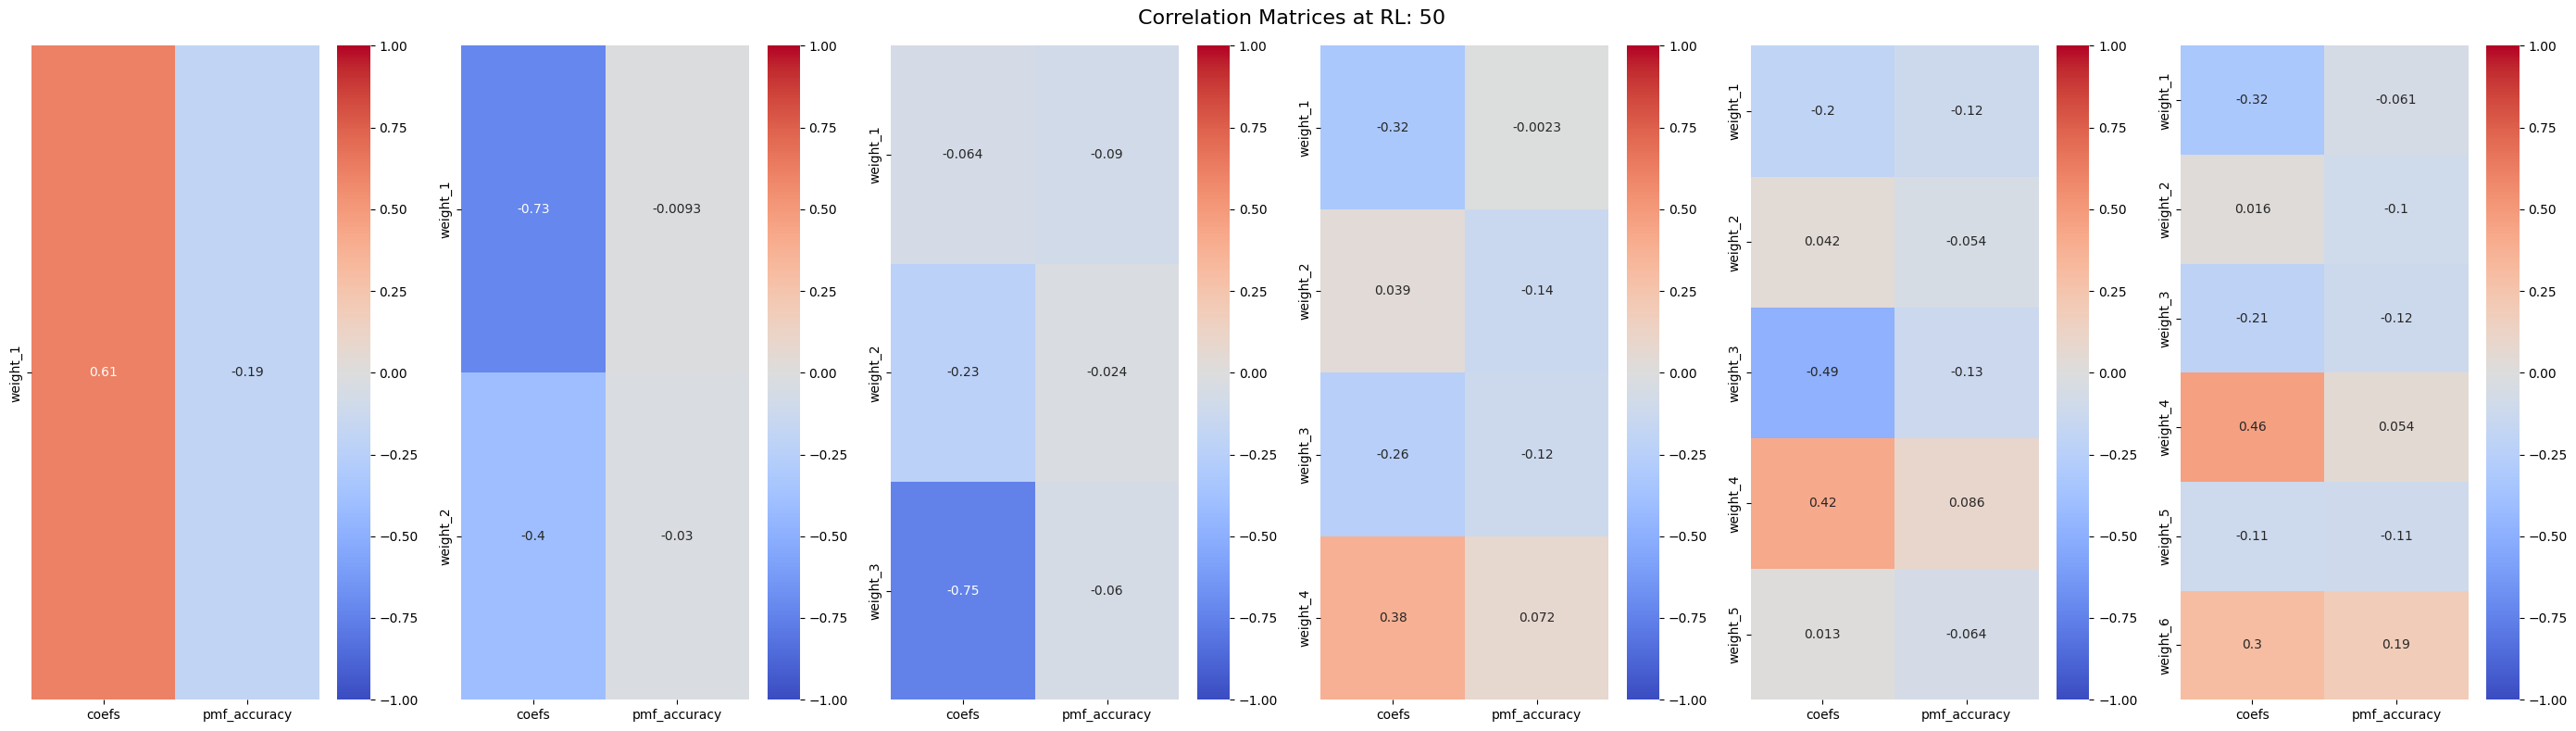

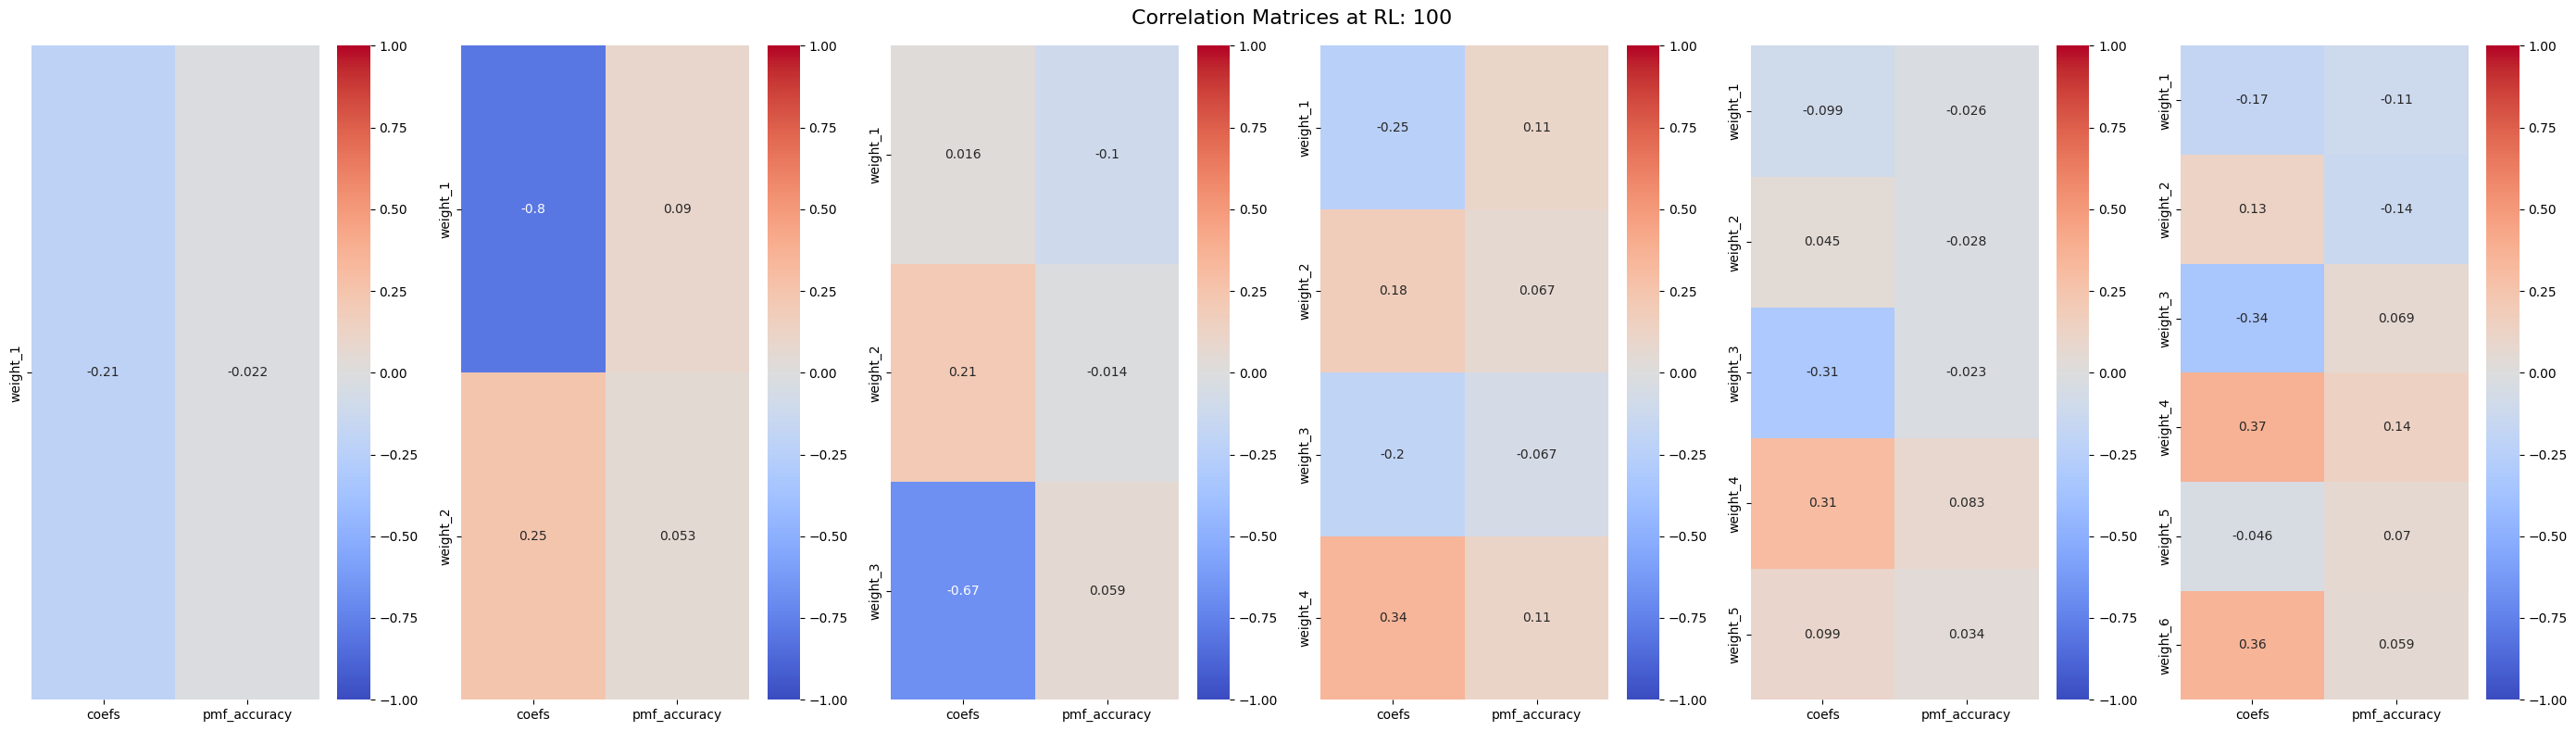

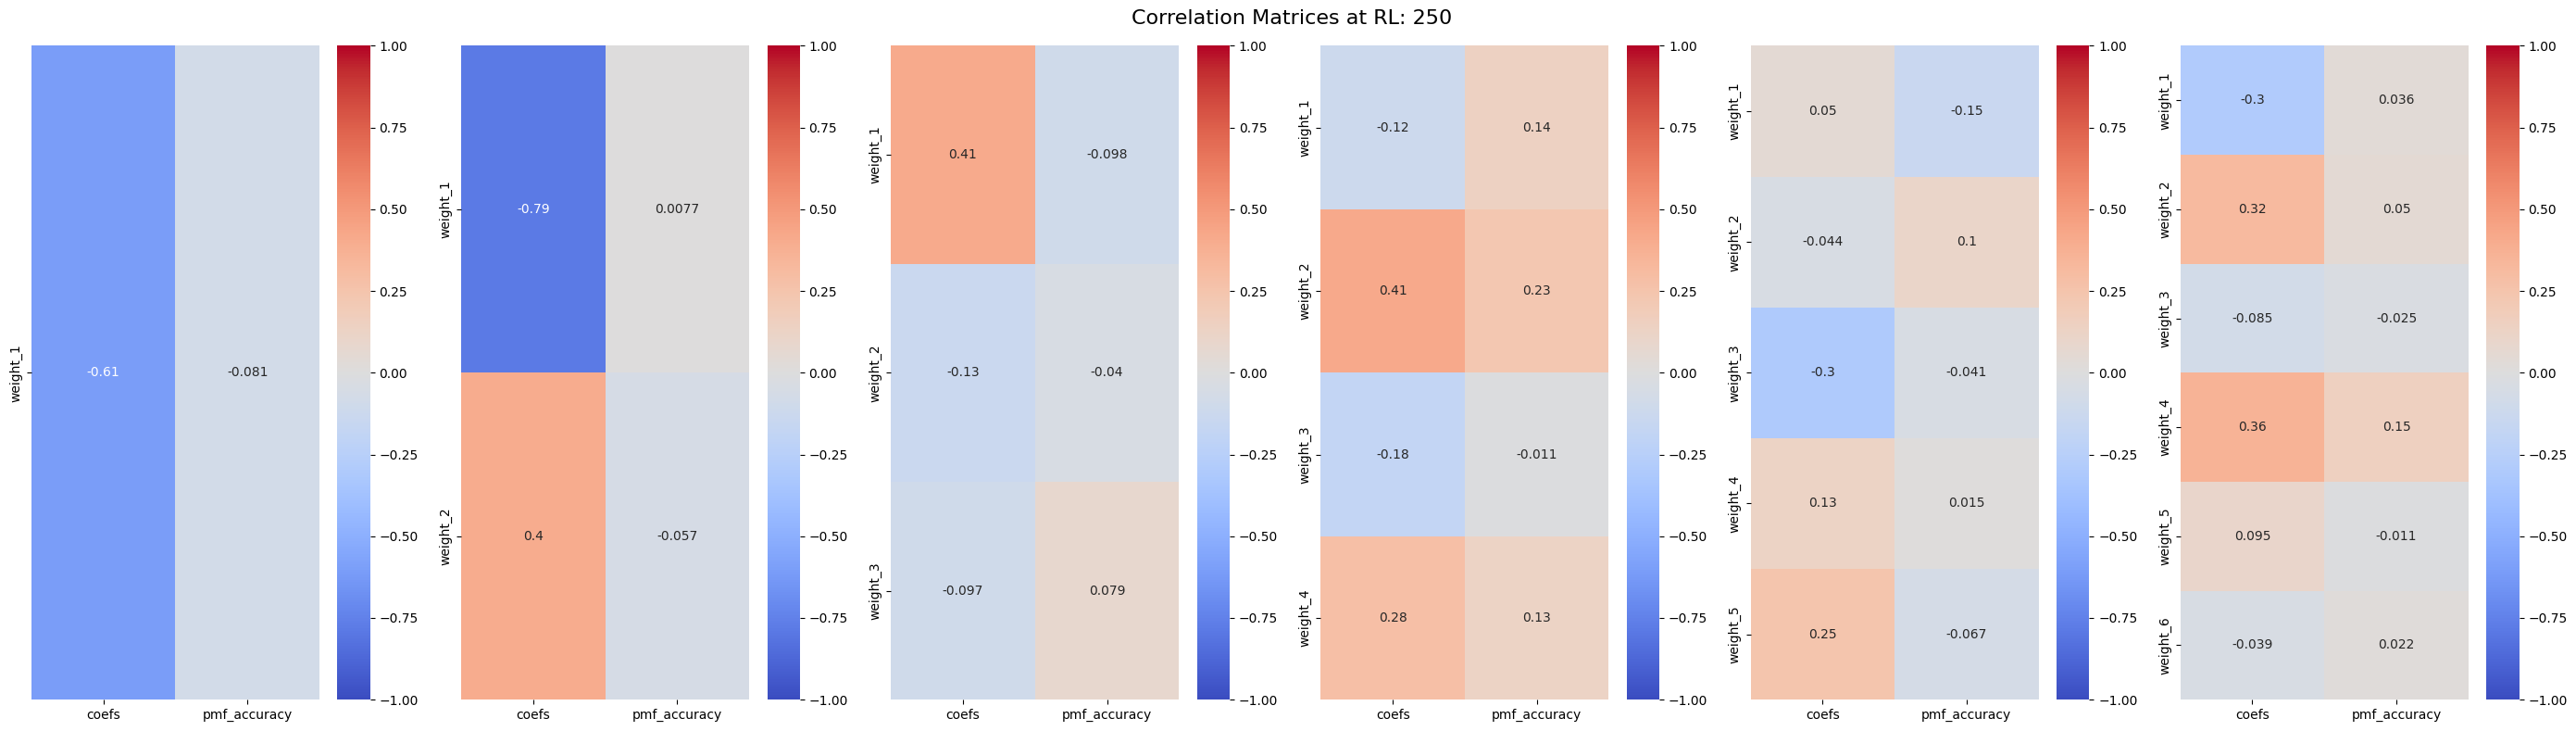

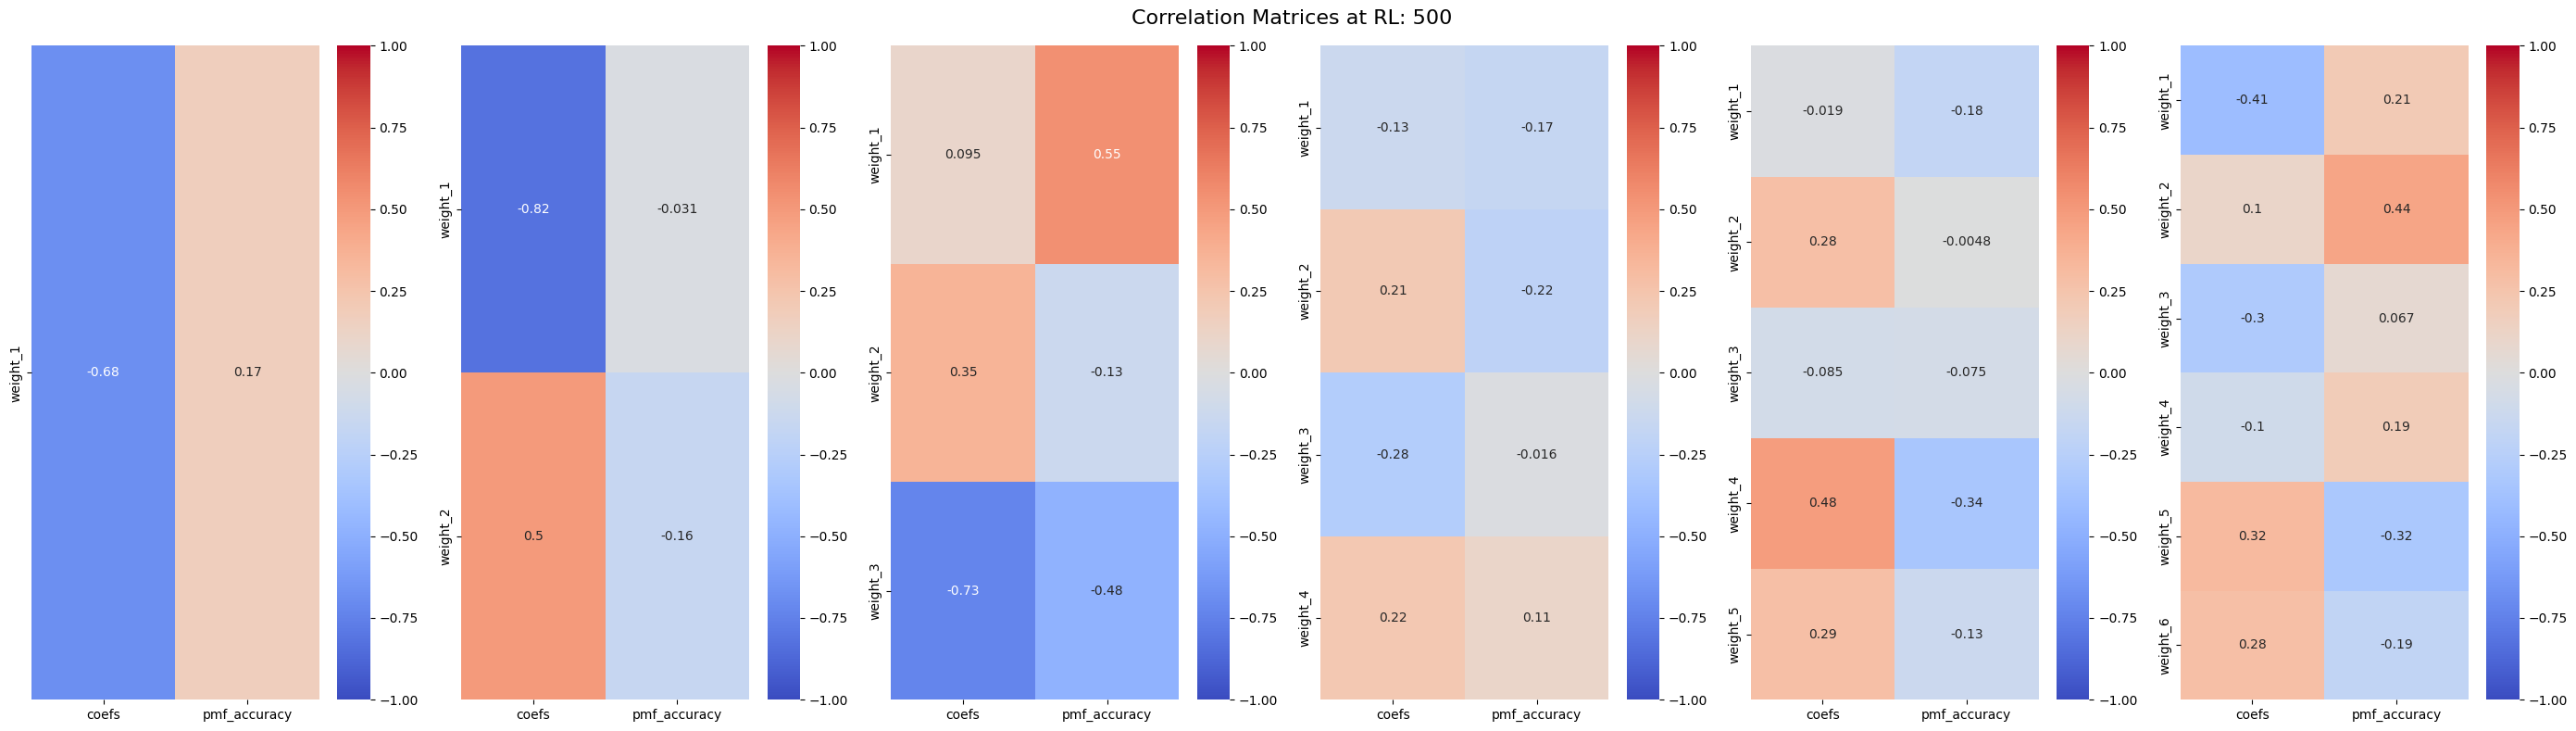

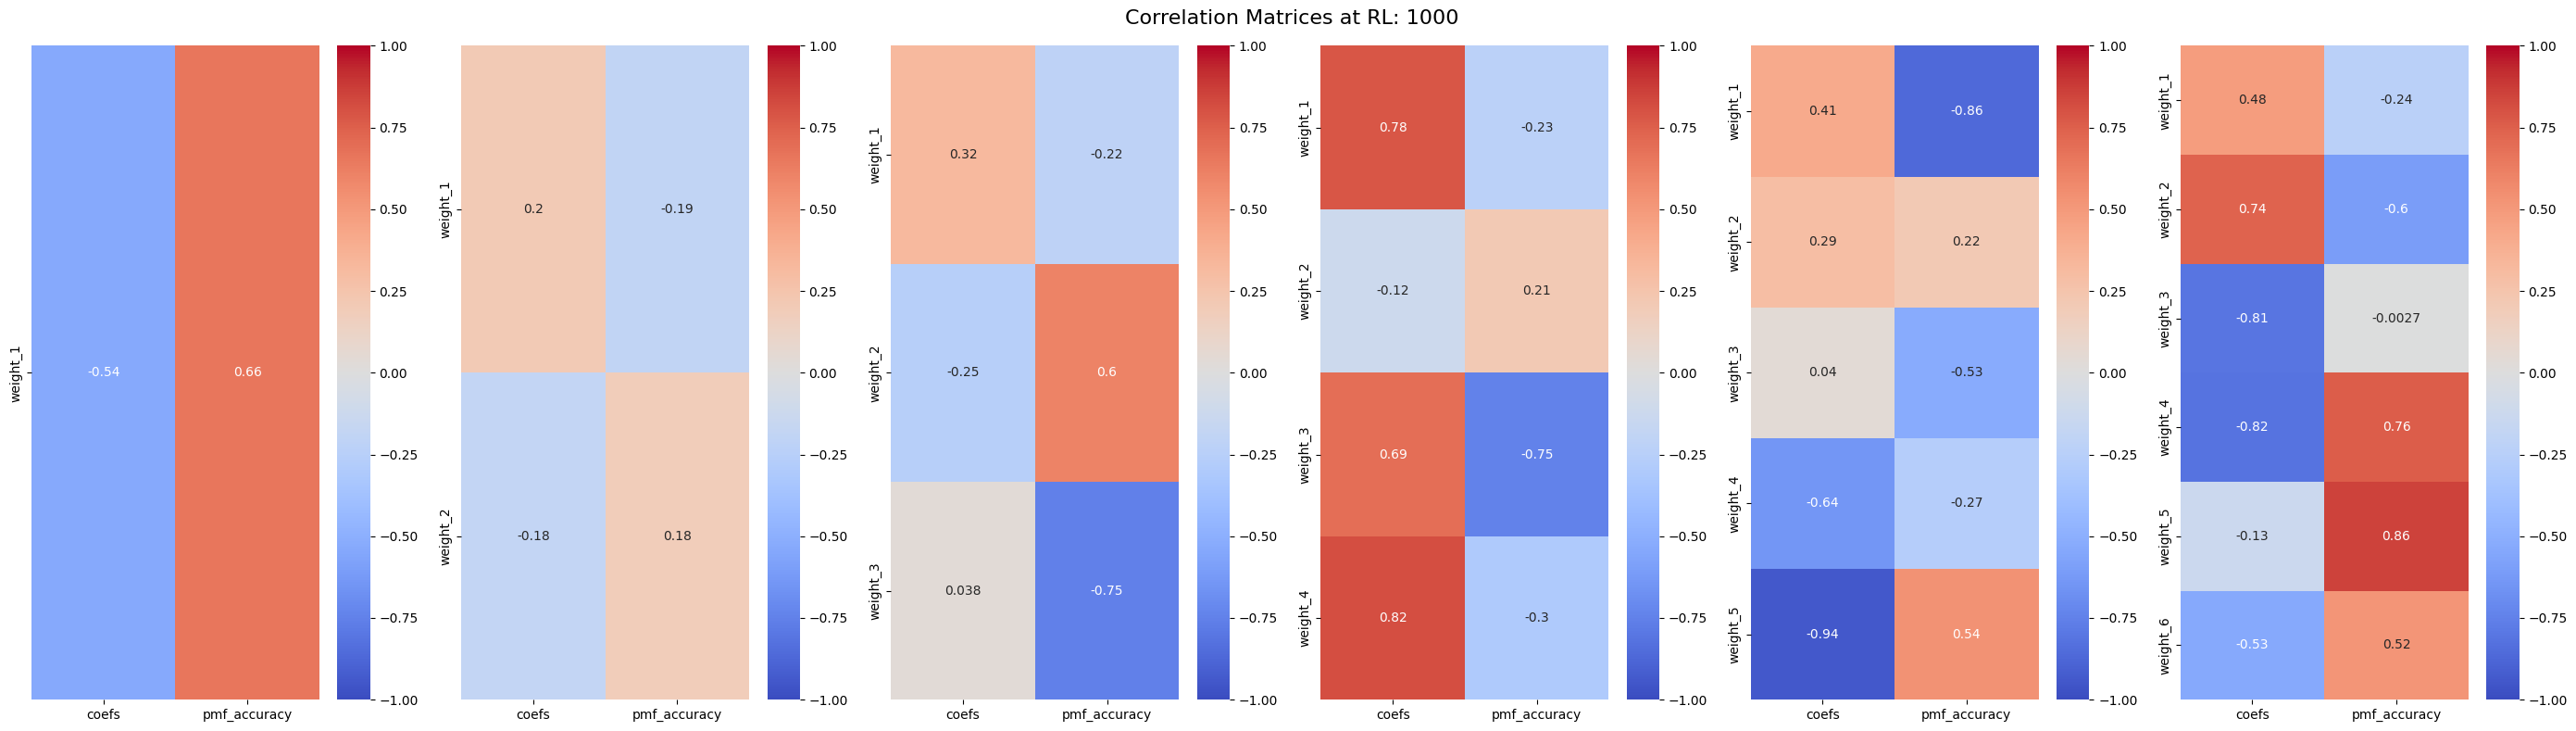

In [227]:
create_correlation_matrices()